In [48]:
import numpy as np
import scipy
import daqp
import numpy as np
from ctypes import * 
import ctypes.util
from sympy import Matrix
import matplotlib.pyplot as plt

from generate_mpqp_v2 import generate_qp
from generate_mpqp_v2 import generate_rhs
from self_implement_daqp import daqp_self

import torch
from torch_geometric.data import Data,Batch
from torch_geometric.loader import DataLoader

import torch.nn.functional as func
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


In [30]:
# Generate general setup
n=2     # number of variables
m=5     # number of constraints
nth = 2
H,f,F,A,b,B = generate_qp(n,m)
sense = np.zeros(m, dtype=np.int32)
blower = np.array([-np.inf for i in range(m)])

train_it = 1000
# only change theta
x_train = np.zeros((train_it,n))
lambda_train = np.zeros((train_it,m))
train_iterations = np.zeros((train_it))
# Generate training set
f_train = np.zeros((train_it,n))
b_train = np.zeros((train_it,m))
theta_train = np.zeros((train_it,nth))
for i in range(train_it):
    theta = np.random.randn(nth)
    theta_train[i,:]=theta
    btot = b + B @ theta
    ftot = f + F @ theta
    b_train[i,:]= btot
    f_train[i,:]= ftot
    
    # solve the system for this theta
    x,fval,exitflag,info = daqp.solve(H,ftot,A,btot,blower,sense)
    # print("Optimal solution:")
    # print(x)
    # print("Exit flag:",exitflag)
    # print("Info:",info)
    x_train[i,:]= x
    lambda_train[i,:]= list(info.values())[4]
    train_iterations[i] = list(info.values())[2]

# Generate test set
test_it =200
x_test = np.zeros((test_it,n))
lambda_test = np.zeros((test_it,m))
test_iterations = np.zeros((test_it))
f_test = np.zeros((test_it,n))
b_test = np.zeros((test_it,m))
for i in range(test_it):
    theta = np.random.randn(2)
    btot = b + B @ theta
    ftot = f + F @ theta
    b_test[i,:]=btot
    f_test[i,:]=ftot
    x,fval,exitflag,info = daqp.solve(H,ftot,A,btot,blower,sense)
    x_test[i,:]= x
    lambda_test[i,:]= list(info.values())[4]
    test_iterations[i] = list(info.values())[2]


In [31]:
# mean of iterations of DAQP
np.mean(train_iterations)

np.float64(2.844)

In [32]:
# get optimal active set
train_active_set = (lambda_train != 0).astype(int) # this line was written by ChatGPT
y_train = torch.tensor((np.hstack((np.zeros((train_it,n)),train_active_set)))) 
test_active_set = (lambda_test != 0).astype(int)
y_test = torch.tensor((np.hstack((np.zeros((test_it,n)),test_active_set)))) 

In [33]:
# Generate the graph from the training data
graph_train = []
graph_test = []

# generat graph structure does not change, only vertex features
#combine H and A
edge_matrix = np.block([[H,A.T],[A,np.zeros((np.shape(A)[0],np.shape(A)[0]))]])
print("edge matrix shape",edge_matrix.shape)

# create edge_index and edge_attributes
edge_index = torch.tensor([])
edge_attr = torch.tensor([])
for j in range(np.shape(edge_matrix)[0]):
    for k in range(np.shape(edge_matrix)[1]):
        # add edge
        if edge_matrix[j,k] != 0:
            edge_index = torch.cat((edge_index,torch.tensor([[j,k]])),0)
            edge_attr = torch.cat((edge_attr,torch.tensor([edge_matrix[j,k]])),0)
edge_index = edge_index.long().T

# create new vectors filled with zeros to capture vertex features better
f1_train = np.hstack((f_train,np.zeros(np.shape(b_train))))
b1_train = np.hstack((np.zeros(np.shape(f_train)),b_train))
eq1_train = np.hstack((np.zeros(np.shape(f_train)),(np.zeros(np.shape(b_train)))))
print(f1_train.shape,b1_train.shape,eq1_train.shape)

# create matrix with vertex features
x_train = torch.tensor([])
for i in range(train_it):
    x_train = torch.tensor([f1_train[i],b1_train[i], eq1_train[i]]).T
    data_point = Data(x= x_train, edge_index=edge_index, edge_attr=edge_attr,y=y_train[i,:])
    #print(data_point)
    # list of graph elements
    graph_train.append(data_point)

f1_test = np.hstack((f_test,np.zeros(np.shape(b_test))))
b1_test = np.hstack((np.zeros(np.shape(f_test)),b_test))
eq1_test = np.hstack((np.zeros(np.shape(f_test)),(np.zeros(np.shape(b_test)))))
print(f1_test.shape,b1_test.shape,eq1_test.shape)

# test graph
x_test = torch.tensor([])
for i in range(test_it):
    x_test = torch.tensor(np.array([f1_test[i],b1_test[i], eq1_test[i]])).T
    data_point = Data(x= x_test, edge_index=edge_index, edge_attr=edge_attr,y=y_test[i,:])
    # list of graph elements
    graph_test.append(data_point)

edge matrix shape (7, 7)
(1000, 7) (1000, 7) (1000, 7)
(200, 7) (200, 7) (200, 7)


In [34]:
# have a look at the graph data

batch = Batch.from_data_list(graph_train)
print(batch.x.shape, batch.edge_index.shape)
print(batch.y.shape)
print(batch.x)

torch.Size([7000, 3]) torch.Size([2, 24000])
torch.Size([7000])
tensor([[ 4.9039,  0.0000,  0.0000],
        [ 1.6985,  0.0000,  0.0000],
        [ 0.0000, -0.4403,  0.0000],
        ...,
        [ 0.0000,  1.4335,  0.0000],
        [ 0.0000,  1.8146,  0.0000],
        [ 0.0000, -0.1155,  0.0000]], dtype=torch.float64)


In [35]:
# running GNN on simulated data 

batch = Batch.from_data_list(graph_train)
loader =DataLoader(graph_train,batch_size = train_it,shuffle = True)
#print(batch)
#print(loader)

# Define a simple GNN
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(3, 16) #(num_vertex_features,hidden_channels)
        #self.hidden = GCNConv(16,16)
        self.conv2 = GCNConv(16, 2) #(hidden_channels,dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        #x = self.hidden(x,edge_index)
        #x = x.relu()
        x = func.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Training loop
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

save_loss = []
save_acc = []
for epoch in range(500):
    epoch_loss = 0
    num_batches = 0
    correct = 0
    total = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x.float(),batch.edge_index)  # Batch contains multiple graphs
        #print(out)
        preds = out.argmax(dim=1) 
        #print(preds)
        loss = func.cross_entropy(out, batch.y.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1
        
        # Compute accuracy
        correct += (preds == batch.y).sum().item()
        total += batch.y.size(0)
        
    avg_loss = epoch_loss / num_batches
    save_loss.append(avg_loss)
    acc = correct / total  # Accuracy
    save_acc.append(acc)
    if epoch %50 ==0:
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f},Accuracy: {acc:.4f}")
        


Epoch 1, Loss: 0.7385,Accuracy: 0.3617
Epoch 51, Loss: 0.4994,Accuracy: 0.7403
Epoch 101, Loss: 0.4729,Accuracy: 0.7357
Epoch 151, Loss: 0.4540,Accuracy: 0.7459
Epoch 201, Loss: 0.4431,Accuracy: 0.7573
Epoch 251, Loss: 0.4349,Accuracy: 0.7623
Epoch 301, Loss: 0.4265,Accuracy: 0.7631
Epoch 351, Loss: 0.4289,Accuracy: 0.7651
Epoch 401, Loss: 0.4244,Accuracy: 0.7696
Epoch 451, Loss: 0.4266,Accuracy: 0.7677


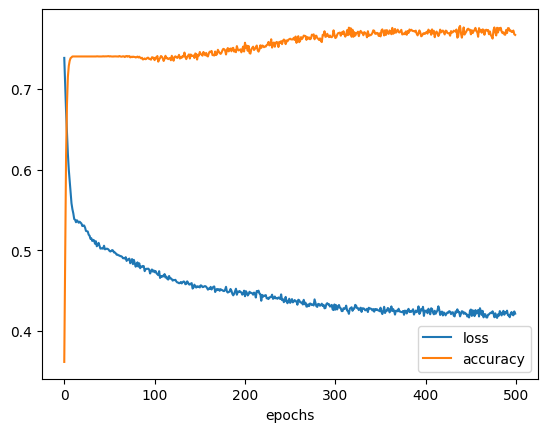

In [36]:
# vizualize loss & accuracy curve
import matplotlib.pyplot as plt

plt.plot(save_loss)
plt.plot(save_acc)
plt.xlabel("epochs")
plt.legend(["loss","accuracy"])


In [37]:
# predict for test data # ChatGPT
# Switch model to evaluation mode
model.eval()

# Assuming you have test data as `test_loader` similar to `loader`
test_loss = 0
num_test_batches = 0

correct = 0
total = 0

test_loader =DataLoader(graph_test,batch_size = test_it,shuffle = True)

with torch.no_grad():  # Disable gradient computation for inference
    for batch in test_loader:
        out = model(batch.x.float(), batch.edge_index)  # Forward pass
        loss = func.cross_entropy(out, batch.y.long())  # Compute the loss
        test_loss += loss.item()  # Accumulate the loss
        num_test_batches += 1
        preds = out.argmax(dim=1)
        correct += (preds == batch.y).sum().item()
        total += batch.y.size(0)
        print(preds.shape)
# Compute average test loss
avg_test_loss = test_loss / num_test_batches
test_acc = correct / total
print(f"Average Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

torch.Size([1400])
Average Test Loss: 0.4111, Test Accuracy: 0.7771


In [43]:
# time comparison of optimization algorithm with/without ML
model.eval()

time_before = np.zeros(500)
time_after = np.zeros(500)
for i in range(500):
    theta = np.random.randn(nth)
    btot = b + B @ theta
    ftot = f + F @ theta
    f1 = np.hstack((ftot,np.zeros(np.shape(btot))))
    b1 = np.hstack((np.zeros(np.shape(ftot)),btot))
    eq1 = np.hstack((np.zeros(np.shape(ftot)),(np.zeros(np.shape(btot)))))

    x_input = torch.tensor([f1,b1, eq1]).T
    data_point = Data(x= x_input, edge_index=edge_index, edge_attr=edge_attr)   
    loader_one_datapoint =DataLoader([data_point],batch_size = 1,shuffle = True)

    for batch in loader_one_datapoint:
        out = model(batch.x.float(), batch.edge_index)  # Forward pass
        num_test_batches += 1
        preds = out.argmax(dim=1)
        #print(preds)

    A_active = A[preds[2:].bool()]
    b_active = btot[preds[2:].bool()]
    sense_new = np.zeros(len(b_active), dtype=np.int32)
    blower_new = np.array([-np.inf for i in range(len(b_active))])
    #print(H.shape,ftot.shape,A_active.shape,b_active.shape,blower_new.shape,sense_new.shape)

    x,fval,exitflag,info = daqp.solve(H,ftot,A,btot,blower,sense)
    # print("Optimal solution:")
    # print(x)
    # print("Exit flag:",exitflag)
    # print("Info:",info)
    time_before[i]= list(info.values())[0]

    x,fval,exitflag,info = daqp.solve(H,ftot,A_active,b_active,blower,sense)
    # print("Optimal solution:")
    # print(x)
    # print("Exit flag:",exitflag)
    # print("Info:",info)
    time_after[i]= list(info.values())[0]

c:\Users\Ellaa\Documents\Studium\Master Data Science\Master thesis\.venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


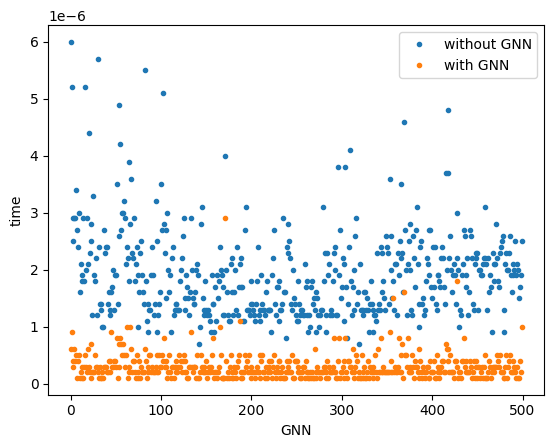

In [44]:
# vizualize time difference

plt.plot(time_before,'.',)
plt.plot(time_after,'.',)
plt.xlabel("GNN")
plt.ylabel("time")
plt.legend(["without GNN","with GNN"])

([<matplotlib.axis.XTick at 0x26cae2ee550>,
 [Text(1, 0, 'without GNN'), Text(2, 0, 'with GNN')])

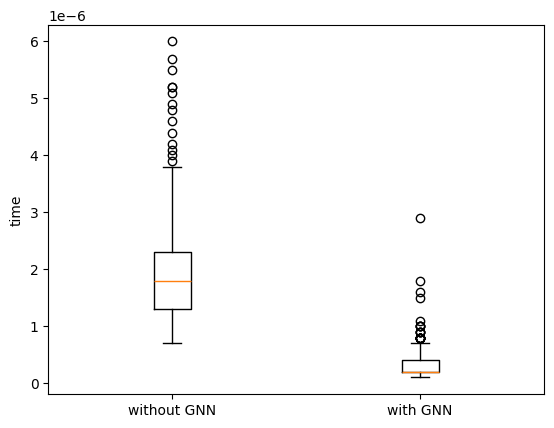

In [47]:
plt.boxplot([time_before,time_after])
plt.ylabel("time")
plt.xticks([1, 2], ['without GNN', 'with GNN'])